# This is Cartography put together into one place. 

# METHODS SECTION
- All the methods I use throughout this notebook is all together up here. 

### Taking the result strains from reading in the metadata and concatenating it to the principal components (where each row is joined with one genome)

In [237]:
"""
principal_Df -- Data from data reduction (-T-SNE, MDS, etc) (pandas DataFrame)
result_metadata -- the metadata that is being read in (Pandas DataFrame)
fields, the parts of metadata that should be concatenated with princiapl_Df (list)
"""
def concatenate_results_with_strain_data(principal_Df,result_metadata,fields):
    finalDf = pd.concat([principal_Df, result_metadata[fields]], axis = 1)
    return finalDf

### Altair method for easy tooltip/brushing below

In [238]:
"""
Defining Fields:
finalDf: The data that is used to generate the scatter plot (pandas DataFrame)
x, the data you want on the x axis (string)
y, the data you want on the y axis (string)
Titlex,the name you want on the x axis (string)
Titley, the name you want on the y axis (string)
Tooltip, when scanning over a point, the data you want avaiable (list)
Color, what the scatterplot is colored by (String)
"""
def scatterplot_with_tooltip_interactive(finalDf,x,y,Titlex,Titley,ToolTip,color):
    import altair as alt
    brush = alt.selection(type='interval', resolve='global')
    chart = alt.Chart(finalDf).mark_circle(size=60).encode(
        x=alt.X(x,title=Titlex),
        y=alt.X(y,title=Titley),
        color=color,
        tooltip=ToolTip
    ).interactive()
    chart.display()
    #return chart

### Linking tree with plots brush

In [239]:
"""
dataframe: dataframe including node data and dimensionality reduction data (Pandas Dataframe)
list_of_data: list of all the names of the columns in the dataframe for which you want graphs: goes in the order of [x1,y1,x2,y2,x3,y3] etc.(list)
list_of_titles: list of all the TITLES you want for each axis: goes in order of[x1,y1,x2,y2,x3,y3] etc.(list)
color: what the data should be colored by (string)
ToolTip: when hovering over the data, what data should be shown (list)
"""
def linking_tree_with_plots_brush(dataFrame,list_of_data,list_of_titles,color,ToolTip):
    list_of_chart = []
    if(len(list_of_data) % 2 != 0 or len(list_of_titles) % 2 != 0):
        raise Exception('The length of list_of_data and the length of list_of_titles should not be odd.')
    else:
        import altair as alt
        base = alt.Chart(dataFrame)
        brush = alt.selection(type='interval', resolve='global')
        tree_name = base.mark_circle().encode(
            x=alt.X(
                "date:Q",
                scale=alt.Scale(domain=(node_df["date"].min() - 0.2, node_df["date"].max() + 0.2)),
                title="Date"
            ),
            y=alt.Y(
                "y:Q",
                title=""
            ),
            color=alt.condition(brush, color, alt.ColorValue('gray')),
            tooltip=ToolTip
        ).add_selection(brush).properties(width=400,height=250)
        list_of_chart.append(tree_name)
        
        for i in range(0,len(list_of_data) - 1,2):
            if(i == len(list_of_data)):
                break
            chart = base.mark_circle(size=60).encode(
            x=alt.X(list_of_data[i],title=list_of_titles[i]),
            y=alt.X(list_of_data[i + 1],title=list_of_titles[i + 1]),
            color=alt.condition(brush, color, alt.ColorValue('gray')),
            tooltip=ToolTip
            ).add_selection(
                brush
            ).properties(
                width=250,
                height=250
            )
            list_of_chart.append(chart)
        return list_of_chart

### Reading in the Fasta File
- I used BioPython to parse the Fasta file into two numpy Arrays: Genomes and Strains. 

In [219]:
#work on making this work

import pandas as pd
import numpy as np
from Bio import SeqIO
strains = []
genomes = []
for record in SeqIO.parse('C:/Users/srava/BedfordProjects/zika/results/aligned.fasta', "fasta"):
    strains.append(str(record.id))
    genomes.append(str(record.seq))

#### Checking to make sure the file I picked is a aligned Fasta file / is the file I wanted

In [220]:
len(strains)
print(len(genomes[0]) == len(genomes[1]))
print(len(genomes))

True
519


In [221]:
strains[:5]

['DOM/2016/MA_WGS16_024',
 'DOM/2016/BB_0180',
 'DOM/2016/BB_0115',
 'DOM/2016/BB_0208',
 'DOM/2016/MA_WGS16_007']

# Creating the Distance Matrix
- I used Hamming Distance to find the pairwise distance between each genome and each other genome, effectively creating a similarity/distance matrix
    - In my Hamming Distance method, I only counted something as a different if it was a mismatch between the nucleotides (A,G,C, or T), not gaps (as that was throwing off the algorithm too much for smaller strains)
- I then used Seaborn to generate a heatmap to make sure the matrix looked correct

In [12]:
# Return the Hamming distance between string1 and string2.
# string1 and string2 should be the same length.
def hamming_distance(array1, array2): 
    # Start with a distance of zero, and count up
    distance = 0
    # Loop over the indices of the string
    L = len(array1)
    for i in range(L):
        # Add 1 to the distance if these two characters are not equal
        if array1[i] != array2[i] and array1[i] != 'N' and array2[i] != 'N':
            distance += 1
    # Return the final count of differences
    return distance

In [1]:
#Using the Hamming distance to create a similarity matrix
numbers = []
matrixOfNum = []
for i in range(0, len(genomes)):
    for j in range(0,len(genomes)):
        num = hamming_distance(genomes[i],genomes[j])
        numbers.append(num)
    matrixOfNum.append(numbers)
    numbers = []
similarity_matrix = pd.DataFrame(matrixOfNum, columns = ["strain " + str(i) for i in range(1,len(matrixOfNum) + 1)], dtype="float")
print(similarity_matrix.head())

NameError: name 'genomes' is not defined

AxesSubplot(0.125,0.125;0.62x0.755)


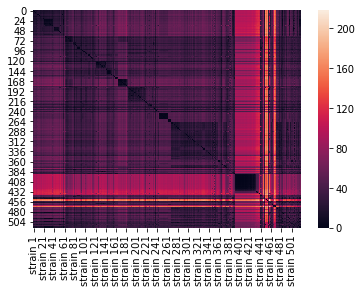

In [61]:
import seaborn as sns
print(sns.heatmap(similarity_matrix))

##### I read it out to a csv file to cut processing time for each run-through

In [14]:
similarity_matrix = similarity_matrix.to_csv("DistanceMatrix",sep=',',index=False)

## Note:
- After running it once, You don't need to run the distance matrix code again : Just read it in like below.

In [222]:
similarity_matrix = pd.read_csv("DistanceMatrix")

AxesSubplot(0.125,0.125;0.62x0.755)


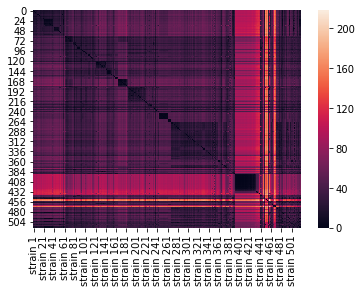

In [223]:
import seaborn as sns
print(sns.heatmap(similarity_matrix))

# Reading in the Metadata
- The metadata is used for getting the region, country, etc of different strains. This data is used to color the clusters.
- The metadata contains all of the possible sampled strains, so many of these will not be in the genomes from the aligned file, probably because the strains were corrupted, too short, etc. 
- We merge this metadata with the strains we have in the aligned file to get a list of all of the strains that match between both. It should come out to the amount of strains in the aligned file.

In [224]:
#merging my final dataframe with their regions and strain names
metadata_df = pd.read_csv(r'C:\Users\srava\BedfordProjects\zika\results\metadata.tsv', delimiter='\t')

In [225]:
metadata_df.head()

,strain,virus,accession,date,region,country,division,city,db,segment,authors,url,title,journal,paper_url
0,1_0015_PF,zika,KX447511,2014-01-XX,oceania,french_polynesia,french_polynesia,french_polynesia,genbank,genome,Pettersson et al,https://www.ncbi.nlm.nih.gov/nuccore/KX447511,How Did Zika Virus Emerge in the Pacific Islan...,"MBio 7 (5), e01239-16 (2016)",https://www.ncbi.nlm.nih.gov/pubmed/27729507
1,1_0016_PF,zika,KX447520,2014-01-XX,oceania,french_polynesia,french_polynesia,french_polynesia,genbank,genome,Pettersson et al,https://www.ncbi.nlm.nih.gov/nuccore/KX447520,How Did Zika Virus Emerge in the Pacific Islan...,"MBio 7 (5), e01239-16 (2016)",https://www.ncbi.nlm.nih.gov/pubmed/27729507
2,1_0030_PF,zika,KX447515,2013-11-XX,oceania,french_polynesia,french_polynesia,french_polynesia,genbank,genome,Pettersson et al,https://www.ncbi.nlm.nih.gov/nuccore/KX447515,How Did Zika Virus Emerge in the Pacific Islan...,"MBio 7 (5), e01239-16 (2016)",https://www.ncbi.nlm.nih.gov/pubmed/27729507
3,1_0035_PF,zika,KX447514,2014-01-XX,oceania,french_polynesia,french_polynesia,french_polynesia,genbank,genome,Pettersson et al,https://www.ncbi.nlm.nih.gov/nuccore/KX447514,How Did Zika Virus Emerge in the Pacific Islan...,"MBio 7 (5), e01239-16 (2016)",https://www.ncbi.nlm.nih.gov/pubmed/27729507
4,1_0038_PF,zika,KX447517,2014-01-XX,oceania,french_polynesia,french_polynesia,french_polynesia,genbank,genome,Pettersson et al,https://www.ncbi.nlm.nih.gov/nuccore/KX447517,How Did Zika Virus Emerge in the Pacific Islan...,"MBio 7 (5), e01239-16 (2016)",https://www.ncbi.nlm.nih.gov/pubmed/27729507


In [226]:
metadata_df.shape

(745, 15)

In [227]:
#making a dataframe out of the strains from the alignment file to merge with the metadata
strains_df = pd.DataFrame(strains)
strains_df.columns = ['strain']

In [228]:
strains_df.shape

(519, 1)

In [229]:
#Merging strains and metadata 
result_strains = pd.merge(strains_df,metadata_df, on='strain')

In [230]:
#checking that no strains were lost
result_strains.shape

(519, 15)

In [231]:
np.setdiff1d(strains_df['strain'].unique(),metadata_df['strain'].unique())

array([], dtype=object)

# Running PCA on the Dataset
- I used sklearn.decomposition to run PCA (source code linked [here][1]
- I ran it with 10 components, and with my precomputed metric (or similarity_matrix)
- I then read it into a [Pandas DataFrame][2] for ease of use. 
[1]: https://github.com/scikit-learn/scikit-learn/blob/1495f6924/sklearn/decomposition/pca.py#L104
[2]: https://github.com/pandas-dev/pandas/blob/v0.25.0/pandas/core/frame.py#L304-L8450

In [232]:
from sklearn.decomposition import PCA

#performing PCA on my pandas dataframe 
pca = PCA(n_components=10,svd_solver='full') #can specify n, since with no prior knowledge, I use None
principalComponents = pca.fit_transform(similarity_matrix)
principalDf = pd.DataFrame(data = principalComponents, columns = ["principal component " + str(i) for i in range(1,11)])

In [233]:
principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,-149.266117,141.271180,232.168432,-56.946880,-29.019579,8.972298,7.011067,5.233502,-15.290198,-3.476272
1,-181.210494,123.065436,223.655927,-50.548695,-27.427517,6.625854,7.549977,4.123703,-14.774765,-4.167120
2,-91.117696,154.173783,231.767323,-57.702244,-33.790820,5.204061,9.609953,4.458384,-14.947945,4.025742
3,-112.916854,160.376105,239.284416,-60.439406,-30.258784,6.379793,10.604413,9.188806,-13.696823,-4.407198
4,-29.175747,184.439204,235.913699,-49.545655,-21.389239,-1.694885,9.422272,20.831208,15.286669,9.158867


## Taking the result strains from reading in the metadata and concatenating it to the principal components (where each row is joined with one genome)

## Note: 
- Methods like the one below will be reused -- when one is called there will be a link back to where the code is defined/ to a methods section at the bottom.

In [235]:
finalDf = concatenate_results_with_strain_data(principalDf,result_strains,['region','strain','country'])

In [236]:
finalDf.shape

(519, 13)

### Explained Variance: 
- It tells you for each principal component, how much variance in the data is it accounting for? Usually you'd like to see that the first two principal components account for ~ 80% of the variance.

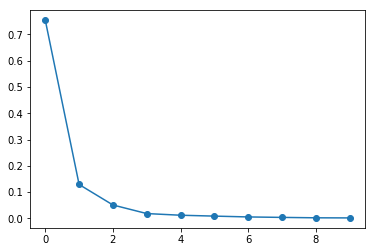

In [26]:
#explained variance for PCA plot below
import matplotlib.pyplot as plt
plt.plot(pca.explained_variance_ratio_, marker="o")

In [27]:
pca.explained_variance_

array([213659.87501795,  36582.8769128 ,  14489.80037182,   5243.46709973,
         3441.20533304,   2501.79107577,   1602.92365402,   1107.51172852,
          669.17672812,    549.63343959])

# Visualizing PCA in Altair
- Visualzing both PC1 (x) and PC2(y), and PC3(x) and PC4(y) in seperate plots

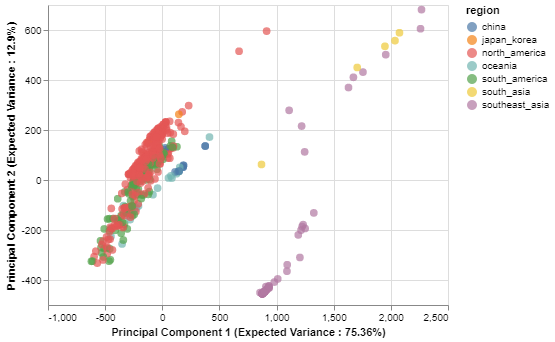

In [39]:
scatterplot_with_tooltip_interactive(finalDf,'principal component 1','principal component 2','Principal Component 1 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
    'Principal Component 2 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")", ['strain', 'region'],'region') 

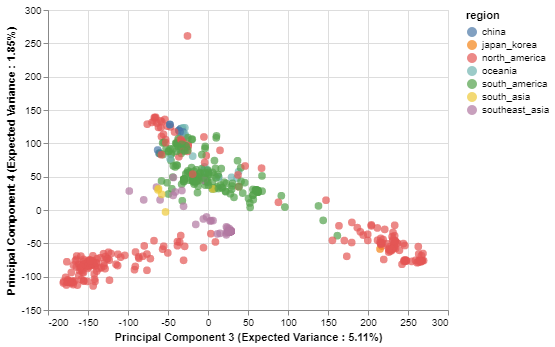

In [40]:
scatterplot_with_tooltip_interactive(finalDf,'principal component 3','principal component 4','Principal Component 3 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[2]*100,2)) + ")",
    'Principal Component 4 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[3]*100,2)) + ")", ['strain', 'region'],'region') 

# Creating the Phylogenetic Tree in Altair
- I used Altair to make this tree (Documentation linked [here][1]
- I opened and imported the json from a build from NextStrain ([flu][2], [zika][3], etc)
- The data from the JSON and the Data from the tree are usually a little different, so after merging the two dataframes you may get some errors.

[1]: https://altair-viz.github.io/index.html
[2]: https://github.com/nextstrain/seasonal-flu
[3]: https://altair-viz.github.io/index.html

In [41]:
import altair as alt
from augur.utils import json_to_tree
import json
import pandas as pd

In [42]:
# Import modules
with open('Data/zika_tree.json') as fh:
    json_tree_handle = json.load(fh)
#json_tree_handle = json.loads(requests.get("http://data.nextstrain.org/zika_tree.json").text)
# Download tree JSON file used by auspice. Despite its filename extension, the data are compressed.
#http = urllib3.PoolManager()
# = http.request('GET', "")


In [43]:
tree = json_to_tree(json_tree_handle)

In [44]:
tree

Clade(branch_length=0, clade=940, name='NODE_0000520', numdate=2007.1438944876675, strain='NODE_0000520', yvalue=510.91459311393555)

In [45]:
node_data = [
    {
        "strain": node.name,
        "date": node.attr["num_date"],
        "y": node.yvalue,
        "region": node.attr["region"],
        "country": node.attr["country"],
        "parent_date": node.parent is not None and node.parent.attr["num_date"] or node.attr["num_date"],
        "parent_y": node.parent is not None and node.parent.yvalue or node.yvalue
    }
    for node in tree.find_clades(terminal=True)
]

In [46]:
node_data[10]

{'strain': 'V20366',
 'date': 2018.7748117727583,
 'y': 507,
 'region': 'south_asia',
 'country': 'india',
 'parent_date': 2018.510007605652,
 'parent_y': 507.5}

In [47]:
node_df = pd.DataFrame(node_data)

In [48]:
node_df.head()

,country,date,parent_date,parent_y,region,strain,y
0,thailand,2013.136893,2010.921473,516.50,southeast_asia,THA/PLCal_ZV/2013,517
1,thailand,2016.665298,2010.921473,516.50,southeast_asia,SI_BKK01,516
2,thailand,2015.043806,2010.006479,514.25,southeast_asia,SV0010/15,515
3,thailand,2016.919918,2011.367398,513.50,southeast_asia,DMSc05684_16,514
4,thailand,2013.722793,2011.367398,513.50,southeast_asia,SK403/13AS,513


In [49]:
node_df["y"] = node_df["y"].max() - node_df["y"]

In [50]:
node_df["parent_y"] = node_df["parent_y"].max() - node_df["parent_y"]

In [51]:
node_df.shape

(517, 7)

In [52]:
node_df.head()

,country,date,parent_date,parent_y,region,strain,y
0,thailand,2013.136893,2010.921473,0.00,southeast_asia,THA/PLCal_ZV/2013,0
1,thailand,2016.665298,2010.921473,0.00,southeast_asia,SI_BKK01,1
2,thailand,2015.043806,2010.006479,2.25,southeast_asia,SV0010/15,2
3,thailand,2016.919918,2011.367398,3.00,southeast_asia,DMSc05684_16,3
4,thailand,2013.722793,2011.367398,3.00,southeast_asia,SK403/13AS,4


In [53]:
node_df["region"].unique()

array(['southeast_asia', 'south_asia', 'oceania', 'china',
       'north_america', 'south_america', 'japan_korea'], dtype=object)

# Linking the Phylogenetic Tree with the two PCA plots
- This way we can see if the clustering we're noticing in the PCA plots are clusters reminicent of the Phylogenetic tree
- Merged the finalDf (the strain data from the alignment file) with node_df ( the strain data from the tree json) to get a dataframe that has both tree data and alignment data

In [54]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [55]:
merged_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,region,country_x,strain,country_y,date,parent_date,parent_y,y
0,-149.266117,141.271180,232.168432,-56.946880,-29.019579,8.972298,7.011067,5.233502,-15.290198,-3.476272,north_america,dominican_republic,DOM/2016/MA_WGS16_024,dominican_republic,2016.517454,2016.177960,202.0,202
1,-181.210494,123.065436,223.655927,-50.548695,-27.427517,6.625854,7.549977,4.123703,-14.774765,-4.167120,north_america,dominican_republic,DOM/2016/BB_0180,dominican_republic,2016.298426,2015.782991,188.0,188
2,-91.117696,154.173783,231.767323,-57.702244,-33.790820,5.204061,9.609953,4.458384,-14.947945,4.025742,north_america,dominican_republic,DOM/2016/BB_0115,dominican_republic,2016.279261,2015.738263,171.5,172
3,-112.916854,160.376105,239.284416,-60.439406,-30.258784,6.379793,10.604413,9.188806,-13.696823,-4.407198,north_america,dominican_republic,DOM/2016/BB_0208,dominican_republic,2016.303901,2016.145963,205.0,205
4,-29.175747,184.439204,235.913699,-49.545655,-21.389239,-1.694885,9.422272,20.831208,15.286669,9.158867,north_america,dominican_republic,DOM/2016/MA_WGS16_007,dominican_republic,2016.358658,2016.145963,205.0,206


# Linking the Tree with the two other PCA Plots

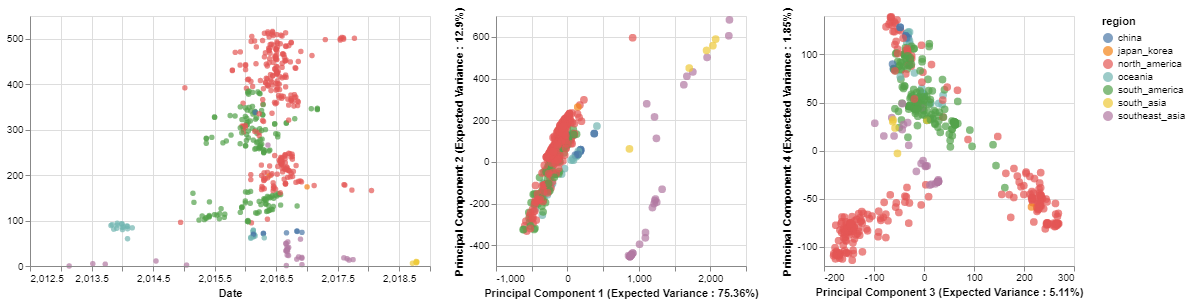

In [146]:
list_of_charts = linking_tree_with_plots_brush(merged_df,['principal component 1','principal component 2','principal component 3','principal component 4'],
                              ['Principal Component 1 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
                               'Principal Component 2 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",
                               'Principal Component 3 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[2]*100,2)) + ")",
                               'Principal Component 4 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[3]*100,2)) + ")"],
                              'region:N', ['strain:N', 'region:N'])
list_of_charts[0]|list_of_charts[1]|list_of_charts[2]

# Running T-SNE on the Dataset 

In [151]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2,metric='precomputed',perplexity = 25.95)
X_transformed = embedding.fit_transform(similarity_matrix)

In [152]:
TSNE_df = pd.DataFrame(X_transformed,columns=['cluster ' + str(i) for i in range(1,3)])
print(TSNE_df.head())

   cluster 1  cluster 2
0 -14.679051   2.359403
1 -16.085659   1.533195
2 -15.802236   2.248125
3 -16.689449   2.549734
4 -17.021284   2.646365


In [159]:
finalDf = concatenate_results_with_strain_data(TSNE_df,result_strains,['strain','region'])

In [160]:
finalDf.shape

(519, 4)

In [161]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [164]:
merged_df.shape

(486, 9)

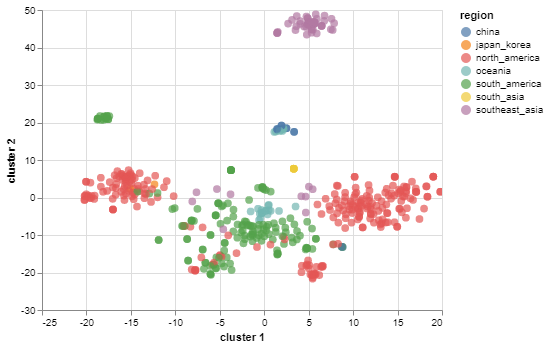

In [166]:
scatterplot_with_tooltip_interactive(finalDf,'cluster 1','cluster 2',"cluster 1","cluster 2",['strain','region'],'region')

# Linking Tree to T-SNE plot

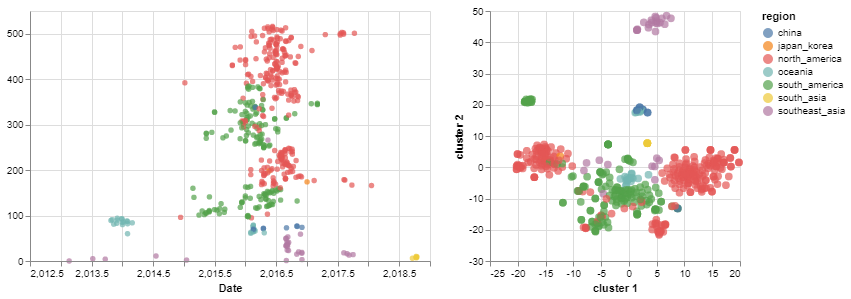

In [170]:
list_of_chart = linking_tree_with_plots_brush(merged_df,['cluster 1','cluster 2'],['cluster 1','cluster 2'],'region:N',["region:N","strain:N"])
list_of_chart[0]|list_of_chart[1]

# Running MDS on the Dataset

In [185]:
from sklearn.manifold import MDS
embedding = MDS(n_components=10,metric=True,dissimilarity='precomputed')
X_transformed = embedding.fit_transform(similarity_matrix)

In [186]:
raw_stress = embedding.stress_
normalized_stress = np.sqrt(raw_stress /((similarity_matrix.values.ravel() ** 2).sum() / 2))
print(normalized_stress.round(2))

0.12


In [187]:
MDS_df = pd.DataFrame(X_transformed,columns=['cluster ' + str(i) for i in range(1,11)])
print(MDS_df.head())

   cluster 1  cluster 2  cluster 3  cluster 4  cluster 5  cluster 6  \
0   1.054422   2.130662  14.708406  -2.684228  17.404064  -1.270762   
1   1.151639   2.164732  13.698266  -1.290837  14.760757   1.361126   
2  -1.593279   0.902889  15.485893   4.268941  13.488322   2.457328   
3   0.445491  -0.222226  15.686022   1.032437  15.579201   6.540052   
4   3.161021  -1.395192  16.990511  -8.841239  20.258383  12.334028   

   cluster 7  cluster 8  cluster 9  cluster 10  
0  15.179425   6.740669   2.590455  -13.412687  
1  15.481617   7.216965   4.322644  -11.415310  
2  22.345753   6.039095   1.186080  -14.419202  
3  19.630839   8.077113   2.209648  -12.911911  
4  15.291055   1.968742   8.153053  -16.546127  


In [188]:
finalDf = concatenate_results_with_strain_data(MDS_df, result_strains, ['strain','region','country'])

In [189]:
finalDf.shape

(519, 13)

In [190]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [192]:
merged_df.shape

(486, 18)

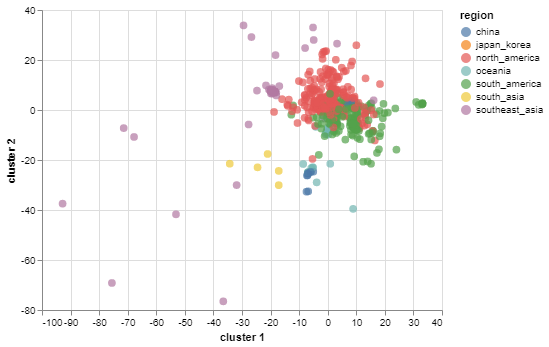

In [202]:
scatterplot_with_tooltip_interactive(finalDf,'cluster 1','cluster 2',"cluster 1","cluster 2",['strain','region'],'region')

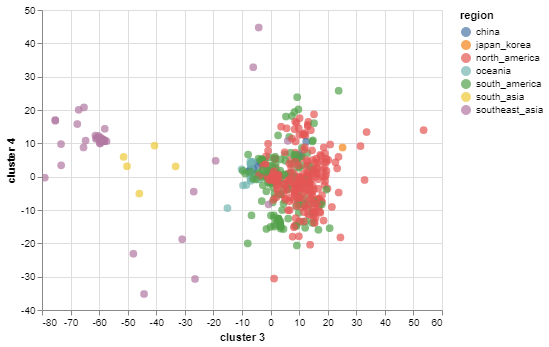

In [198]:
scatterplot_with_tooltip_interactive(finalDf,'cluster 3','cluster 4',"cluster 3","cluster 4",['strain','region'],'region')

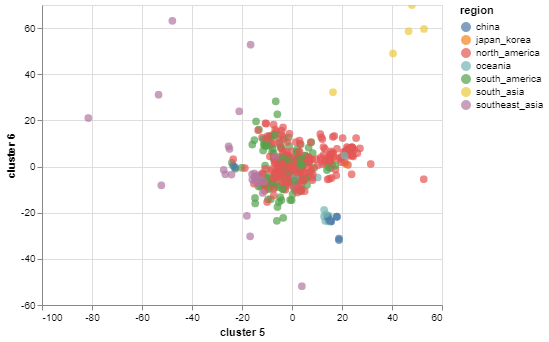

In [197]:
scatterplot_with_tooltip_interactive(finalDf,'cluster 5','cluster 6',"cluster 5","cluster 6",['strain','region'],'region')

# Linking Tree to MDS plot

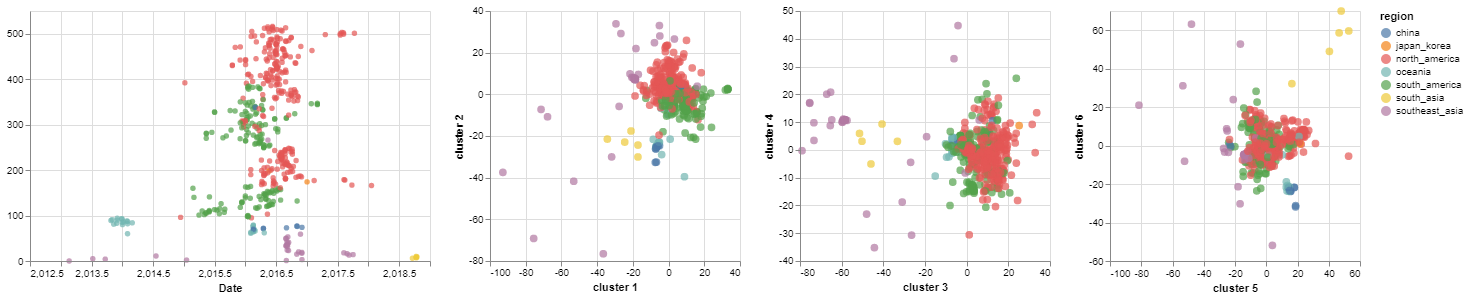

In [201]:
list_of_data_and_titles = ['cluster 1','cluster 2','cluster 3','cluster 4','cluster 5','cluster 6']
list_of_chart = linking_tree_with_plots_brush(merged_df,list_of_data_and_titles,list_of_data_and_titles,'region:N',["region:N","strain:N"])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

# Running UMAP on the Dataset

In [206]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(similarity_matrix)

C:\Users\srava\Miniconda3\lib\site-packages\umap\umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "..\..\..\Miniconda3\lib\site-packages\umap\umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
C:\Users\srava\Miniconda3\lib\site-packages\numba\compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "..\..\..\Miniconda3\lib\site-packages\umap\umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
C:\Users\srava\Miniconda3\lib\site-packages\numba\compiler.py:751: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the obj

In [207]:
UMAP_df = pd.DataFrame(embedding,columns=['cluster ' + str(i) for i in range(1,3)])
print(UMAP_df.head())

   cluster 1  cluster 2
0   6.812156  -5.877115
1   6.600855  -5.965251
2   7.205830  -6.016746
3   7.036717  -6.026123
4   7.840689  -6.450999


In [208]:
finalDf = concatenate_results_with_strain_data(UMAP_df, result_strains, ['strain','region','country'])

In [209]:
finalDf.shape

(519, 5)

In [210]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [211]:
merged_df.shape

(486, 10)

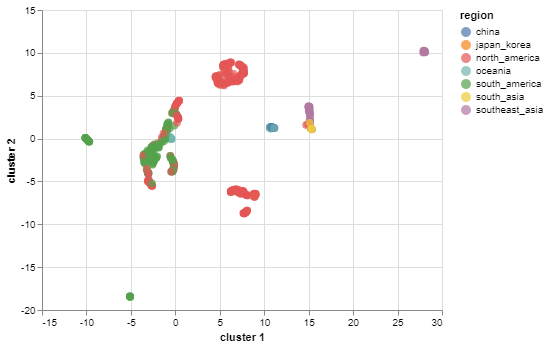

In [212]:
scatterplot_with_tooltip_interactive(finalDf,'cluster 1','cluster 2',"cluster 1","cluster 2",['strain','region'],'region')

# Linking Tree with UMAP plot

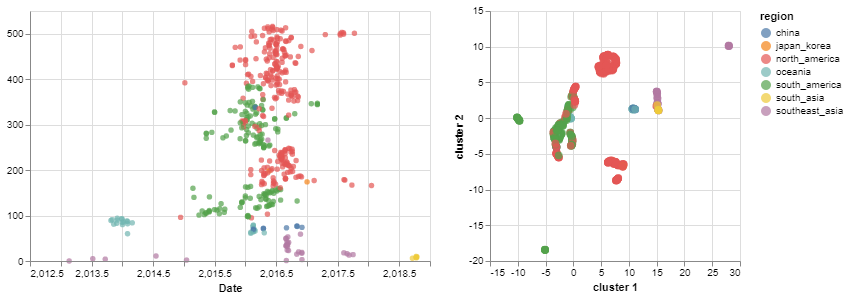

In [213]:
list_of_data_and_titles = ['cluster 1','cluster 2']
list_of_chart = linking_tree_with_plots_brush(merged_df,list_of_data_and_titles,list_of_data_and_titles,'region:N',["region:N","strain:N"])
list_of_chart[0]|list_of_chart[1]

# Notes to Self:

- Fix/Add pairwise plot to graphs
- Collapse cells underneath Markdown headers
- Get docstrings above methods to show up when user presses SHIFT + TAB
- link back to the methods section for user each time method is used